authorName
citedScore
authorName
citingScore
[1.0, 0.55876291623155938, 0.37396980207710273, 0.37396980207710273, 0.32795335628904704, 0.27352745272764539, 0.27352745272764539, 0.27352745272764539, 0.20691553026638104, 0.20691553026638104, 0.20691553026638104, 0.12103782602266644, 0.12103782602266644, 0.12103782602266644, 0.12103782602266644, 0.12103782602266644, 0.12103782602266644, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 3.01577576496 1.56093090495 24
[1.0, 0.55306924770878385, 0.32461158530282114, 0.32461158530282114, 0.27074026946535285, 0.27074026946535285, 0.27074026946535285, 0.27074026946535285, 0.20480710752154971, 0.20480710752154971, 0.20480710752154971, 0.11980447778127234, 0.11980447778127234, 0.11980447778127234, 0.11980447778127234, 0.11980447778127234, 0.11980447778127234, 0.11980447778127234, 0.11980447778127234, 0.11980447778127234, 0.11980447778127234, 0.0, 0.0, 0.0] 3.00210612478 1.5322841088 24


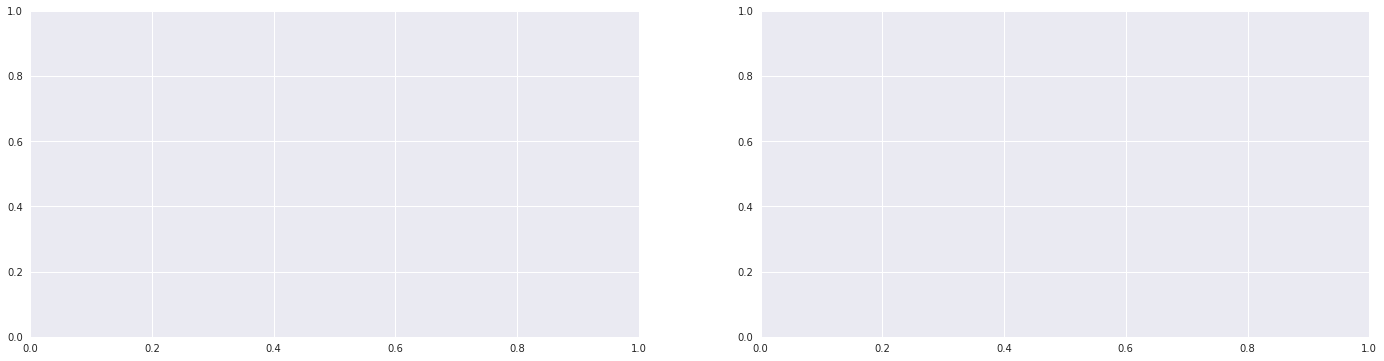

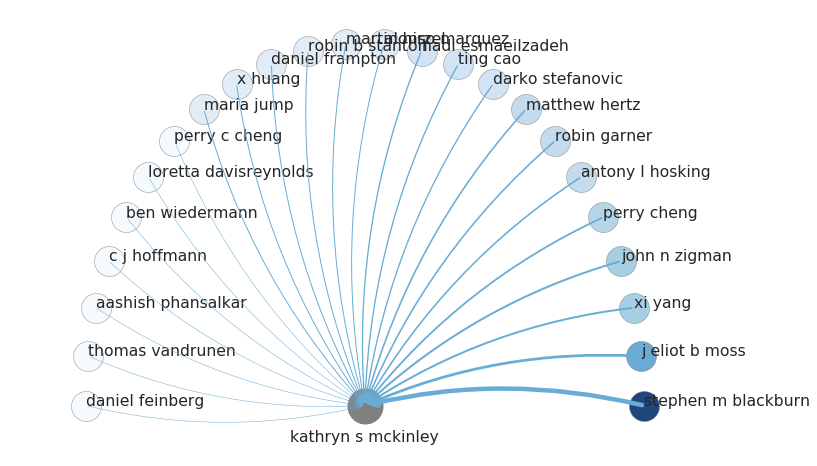

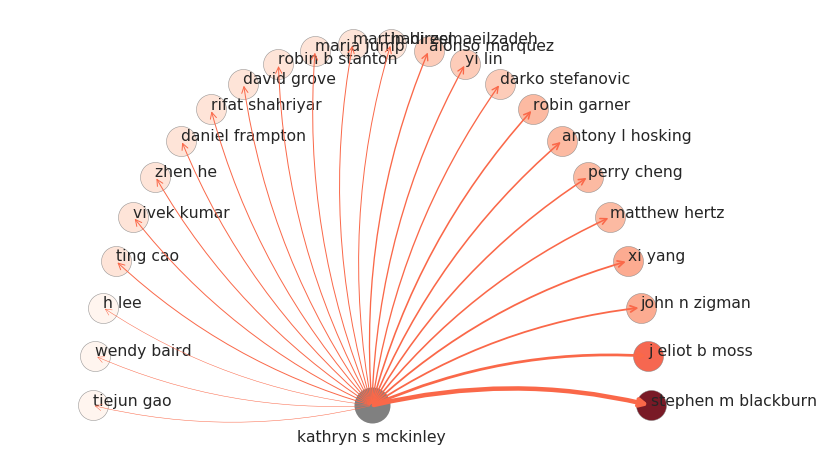

In [8]:
import os, sys
import pandas as pd
from datetime import datetime 
import numpy as np
import networkx as nx
from draw_egonet import *
# initilize plotting packages: seaborn
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

%matplotlib inline
def print_list(ls):
	for line in ls:
		print(line)
person_of_interest = "kathryn s mckinley"

data_dir = '/localdata/u5642715/influenceMapOut/out' 
out_dir = '/localdata/u5642715/influenceMapOut/out'

plot_dir = os.path.join(out_dir, 'figures')

for dir in [data_dir, out_dir, plot_dir]:
	if not os.path.exists(dir):
	    os.makedirs(dir)


# load data into dataframe
cited_df = pd.read_csv(os.path.join(data_dir, 'authors_cited.txt'), sep='\t', header=None, names=['authorName', 'citedScore'])

citing_df = pd.read_csv(os.path.join(data_dir, 'authors_citing.txt'), sep='\t', header=None, names=['authorName', 'citingScore'])

# get the top x influencers
n = 25
cited_df = cited_df.sort_values(by=['citedScore'], ascending=False)
top_n_cited = list(cited_df.head(n))
print_list(top_n_cited)

citing_df = citing_df.sort_values(by=['citingScore'], ascending=False)
top_n_citing = list(citing_df.head(n))
print_list(top_n_citing)

# build a graph structure for the top data
personG = nx.DiGraph()

for index, row in cited_df.head(n).iterrows():
	personG.add_edge(person_of_interest, row['authorName'], weight=float(row['citedScore']))

for index, row in citing_df.head(n).iterrows():
	personG.add_edge(row['authorName'], person_of_interest, weight=float(row['citingScore']))


# define the graph drawing function    
def draw_halfcircle(graph=None, ego=None, ax=None, direction="out", renorm_weights='lin', 
                   plot_setting={'max_marker':30, 'max_line': 4., 'min_line': .5, 
                                 "sns_palette": "RdBu", "out_palette": "Reds", "in_palette": "Blues", 
                                 "num_colors": 100, "delta_text":0.02}):
    ps = plot_setting
    if not ax:
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111)
    sns.set_context("talk", font_scale=1.)
    sns.set_style("white")
    sns.despine()
        
    xroot = 0.
    yroot = 0.
    ax.plot(xroot, yroot, 'o', c=[.5, .5, .5], markersize=1.2*ps['max_marker'], fillstyle='full', mec='0.5')
    ax.text(xroot, yroot-5*ps['delta_text'], ego, horizontalalignment='center')
    
    
    # take the subgraph out as a node list and a weight list
    if direction == "in":
        node_list = [e[0] for e in graph.in_edges(ego)]
        if ego in node_list:
            node_list.remove(ego)
        weight_list = [graph[n][ego]['weight'] for n in node_list]
        node_colors = sns.color_palette(ps['in_palette'], ps['num_colors']) #len(node_list))
        arrow_str = '->'
    else:
        node_list = [e[1] for e in graph.out_edges(ego)]
        if ego in node_list:
            node_list.remove(ego)
        weight_list = [graph[ego][n]['weight'] for n in node_list]
        node_colors = sns.color_palette(ps['out_palette'], ps['num_colors'])
        arrow_str = '<-'
    
    nn = len(node_list)
    edge_color = node_colors[int(ps['num_colors']/2)]
    
    # nomalise these weights to get edge width
    if renorm_weights == 'log':
        weight_max = max( [np.log10(w) for w in weight_list] )
        weight_min = min( [np.log10(w) for w in weight_list] )
        weight_norm = [ (np.log10(w)-weight_min)/(weight_max-weight_min) for w in weight_list ]
    elif renorm_weights == 'lin':
        weight_max = max(weight_list)
        weight_min = min(weight_list)
        weight_norm = [ (w-weight_min)/(weight_max-weight_min) for w in weight_list ]
    print(weight_norm, weight_max, weight_min, nn)
    
    # sort order of edges based on the weight 
    isort = np.argsort(weight_list)
    
    anglelist = np.linspace(np.pi, 0., num=nn)
    iangle = [i for i in range(0, nn, 2) ] + [i for i in range(nn - (nn+1)%2, 0, -2) ]
    #anglelist = anglelist[iangle]
    #print(iangle)
    
    for i, jn in enumerate(isort):
        n = node_list[jn]
        w = weight_norm[jn]
        # node position
        xp = np.cos(anglelist[i]) 
        yp = np.sin(np.abs(anglelist[i])) 
        #print((xp, yp))
        
        # calculate node color index based on its weight
        ci = int( w*(len(node_colors)-1e-3) )
        lw = ps['max_line'] * w + ps['min_line']
        # plot the node
        ax.plot(xp, yp, 'o', c=node_colors[ci], markersize= ps['max_marker'], # markersize=int(sz), 
            alpha=.9, mec='0.5', mew=.5) 
        # add node text 
        h = ax.text(xp, yp, n, horizontalalignment='left')
        # draw arc / arrow 
        ax.annotate("", xy=(xroot, yroot), xycoords='data',
            xytext=(xp, yp), textcoords='data',
            arrowprops=dict(arrowstyle = arrow_str, 
                        color=edge_color, linewidth = lw,
                        connectionstyle="arc3,rad=0.12", ), )
        
    ### TODO: draw color bar
    #cbar = plt.colorbar(cax = ax) #, ticks=[-1, 0, 1])
    #cbar.ax.set_yticklabels(['< -1', '0', '> 1'])  # vertically oriented colorbar
   
    ax.set_xlim((-1.2, 1.2))
    ax.set_ylim((-.1, 1.1))
    ax.axis('off')
    

# draw the graphs
fig = plt.figure(figsize=(24, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

draw_halfcircle(graph=personG, ego=person_of_interest, renorm_weights='log', direction='in')
draw_halfcircle(graph=personG, ego=person_of_interest, renorm_weights='log', direction='out')